In [2]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares, curve_fit

In [3]:
from liquidity.response_functions.trades_impact import get_aggregate_trade_response_features
from liquidity.response_functions.fitting import bin_data_into_quantiles, fit_scale_function

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# LAGS = [10, 20, 50, 80, 100, 130, 150, 200, 300, 500, 700, 1000]
# LAGS = [10, 20, 50, 80, 100, ]#130, 150, 200, 300, 500, 700, 1000]
#LAGS = list(range(1, 5001, 5))

In [6]:
"""

-- Generate series --

Define lags of interest/testing

LAGS = [10, 20, 50, 80, 100, 130, 150, 200, 300, 500, 700, 1000]

RN - difference between log midprice
QN - sum of signed volume

-- Fit scaling form --

Scaling form: RN(data) = R_N(param) * F(QN(data) / Q_N(param))
F(x) = x / (1 + abs(x) ** alpha) ** (beta / alpha)

Final fitting function:

RN(data) = R_N(param) * (QN(data) / Q_N(param))
           / (1 + abs(QN(data) / Q_N(param)) ** alpha) ** (beta / alpha)


"""

'\n\n-- Generate series --\n\nDefine lags of interest/testing\n\nLAGS = [10, 20, 50, 80, 100, 130, 150, 200, 300, 500, 700, 1000]\n\nRN - difference between log midprice\nQN - sum of signed volume\n\n-- Fit scaling form --\n\nScaling form: RN(data) = R_N(param) * F(QN(data) / Q_N(param))\nF(x) = x / (1 + abs(x) ** alpha) ** (beta / alpha)\n\nFinal fitting function:\n\nRN(data) = R_N(param) * (QN(data) / Q_N(param))\n           / (1 + abs(QN(data) / Q_N(param)) ** alpha) ** (beta / alpha)\n\n\n'

## PART 1: generate data

In [7]:
# tsla_df = pd.read_csv('../../data/market_orders/TSLA-2016-R1.csv', header=0,index_col=0)

In [8]:
# def generate_aggregate_feature_series(df_, T, log=False):
#     result = get_aggregate_trade_response_features(df_, T=T) # , log=log
#     data = result.rename(columns={f'R{T}': 'R'})
#     data['T'] = T
#     cols = ['vol_imbalance', 'sign_imbalance', 'T', 'R']
#     return data[cols]

In [9]:
# result_dict = {}
# for N in LAGS:
#     agg_features = generate_aggregate_feature_series(tsla_df, N) # , log=True
#     result_dict[N] = agg_features

In [10]:
result_dict = pickle.load(open('../../data/generated/tsla_aggregate_features_mo.pkl', 'rb'))
MAX_LAG = 700

In [11]:
result_dict[1]

,vol_imbalance,sign_imbalance,T,R
0,-0.508567,-0.597528,1,0.000
1,-0.508567,-0.597528,1,0.000
2,-0.508567,-0.597528,1,-0.095
3,-0.127142,-0.597528,1,-0.010
4,-0.508567,-0.597528,1,-0.090
...,...,...,...,...
757587,-0.861521,-1.433923,1,-0.045
757588,1.258515,1.433923,1,0.015
757589,1.485048,1.433923,1,-0.005
757590,1.258515,1.433923,1,0.035


## PART 2: fit scaling form

In [12]:
def scale_function(x: float, alpha: float, beta: float) -> float:
    return x / (1 + abs(x) ** alpha) ** (beta / alpha)

In [13]:
def aggregate_impact(Q: float, RN: float, QN: float,
                     alpha: float, beta: float) -> float:

    return RN * scale_function(Q / QN, alpha, beta)

In [14]:
# def residuals_(params, x, y):
#     return y - aggregate_impact(x, *params)
#
# def fit_aggregate_impact_ls(x, y):
#
#     num_params = aggregate_impact.__code__.co_argcount - 1
#     # lower_bounds = [0] * num_params
#     # upper_bounds = [np.inf] * num_params
#     # bounds = (lower_bounds, upper_bounds)
#     initial_guess = [0.5] * num_params
#     result = least_squares(residuals_, initial_guess, args=(x, y)) # bounds=bounds
#     return result.x

In [15]:
# result = result_dict[11][['vol_imbalance', 'R']]
# result.replace([np.inf, -np.inf], np.nan, inplace=True)
# result.dropna(inplace=True)
# binned_result = bin_data_into_quantiles(result)
# x = binned_result['vol_imbalance'].values
# y = binned_result['R'].values
#
# param = fit_aggregate_impact_ls(x, y)
# param
# param = fit_scale_function(binned_result)


In [16]:
# param

## PART 3: use the same alpha and beta to fit scaling form for each N

In [17]:
ALPHA = 1.2
BETA = 1.3

In [18]:
def scaling_form(Q: float, RN: float, QN: float) -> float:
    return RN * scale_function(Q / QN, ALPHA, BETA)

In [19]:
def fit_scaling_form_ls(x, y):

    def _residuals(params, x, y):
        return y - scaling_form(x, *params)

    num_params = scaling_form.__code__.co_argcount - 1
    initial_guess = [0.5] * num_params
    result = least_squares(_residuals, initial_guess, args=(x, y),loss='soft_l1')
    return result.x

In [20]:
RN = []
QN = []
for lag in range(1, MAX_LAG):
    result = result_dict[lag][['vol_imbalance', 'R']]
    result.replace([np.inf, -np.inf], np.nan, inplace=True)
    result.dropna(inplace=True)
    binned_result = bin_data_into_quantiles(result, x_col='vol_imbalance', duplicates='drop')
    x = binned_result['vol_imbalance'].values
    y = binned_result['R'].values

    param = fit_scaling_form_ls(x, y)
    RN.append(param[0])
    QN.append(param[1])
    # print(f'For lag {lag}, \n {param} \n')

/var/folders/ht/ftxq182137ngc38c1g4m9ff40000gn/T/ipykernel_85870/1846961299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/ht/ftxq182137ngc38c1g4m9ff40000gn/T/ipykernel_85870/1846961299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result.dropna(inplace=True)
/Users/ana_bugaenko/workspace/another_workspace/liquidity/liquidity/response_functions/fitting.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

[]

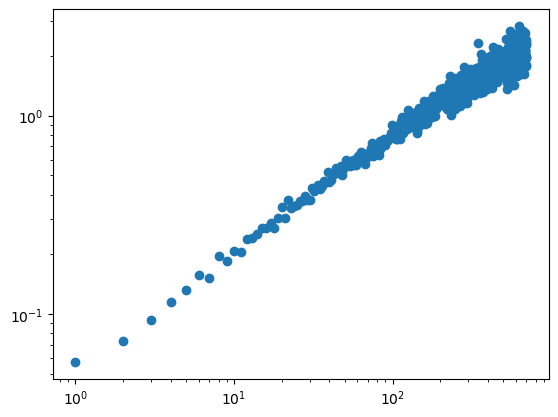

In [21]:
plt.scatter(range(1, MAX_LAG),RN)
plt.loglog()

[]

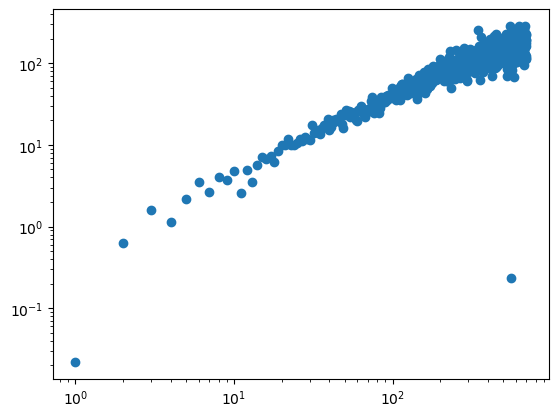

In [22]:
plt.scatter(range(1, MAX_LAG),QN)
plt.loglog()

In [23]:
from powerlaw_function import Fit

In [24]:
x = range(1, MAX_LAG)
xy_df = pd.DataFrame({
    'x_values': x,
    'y_values': RN
})

# Basic Usage
fit = Fit(xy_df, verbose= True)

Fitting pure_powerlaw function using Nonlinear Least-squares fitting method.

For pure_powerlaw fitted using Nonlinear Least-squares;

Pre-fitting parameters:
xmin: 2.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 0.08622253514856783
alpha = 0.48974467443252945

Goodness of fit to data:
D = 0.0673352435530086
bic = -475.4276670293124
Adjusted R-squared = 0.8970714667056042


Using Linear fitting methods to approximation pure_powerlaw fit on Loglog scale.

For pure_powerlaw fitted using OLS;

Pre-fitting parameters:
xmin: 2.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 0.06663204866050852
alpha = 0.5330599419868867

Goodness of fit to data:
D = 0.05157593123209169
bic = -449.0502629707124
Adjusted R-squared = 0.8930845132273064



For pure_powerlaw fitted using GeneralisedRegression;

Pre-fitting parameters:
xmin: 2.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 0.06663204866050852
alpha = 0.5330599419868867

Goodness of fit to data:
D = 0.05157593123209169
b

In [25]:
x = range(1, MAX_LAG)
xy_df = pd.DataFrame({
    'x_values': x,
    'y_values': QN
})

# Basic Usage
fit = Fit(xy_df, verbose= True)

Fitting pure_powerlaw function using Nonlinear Least-squares fitting method.

For pure_powerlaw fitted using Nonlinear Least-squares;

Pre-fitting parameters:
xmin: 2.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 1.4324890393161585
alpha = 0.7384164383339238

Goodness of fit to data:
D = 0.08739255014326648
bic = 6737.709600744123
Adjusted R-squared = 0.7162942813145342


Using Linear fitting methods to approximation pure_powerlaw fit on Loglog scale.

For pure_powerlaw fitted using OLS;

Pre-fitting parameters:
xmin: 2.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 0.8172298947339728
alpha = 0.8316337586182878

Goodness of fit to data:
D = 0.0659025787965616
bic = 6775.546197643785
Adjusted R-squared = 0.7001783305077675



For pure_powerlaw fitted using GeneralisedRegression;

Pre-fitting parameters:
xmin: 2.0

Fitting parameters:
param_names = ['C', 'alpha']
C = 0.8172298947339728
alpha = 0.8316337586182878

Goodness of fit to data:
D = 0.0659025787965616
bic = 67

In [26]:
fit.fit_results_dict

{'pure_powerlaw': <powerlaw_function.powerlaw_function.FitResult at 0x7fe505f65e50>,
 'OLS': <powerlaw_function.powerlaw_function.FitResult at 0x7fe4c2b81160>,
 'GeneralisedRegression': <powerlaw_function.powerlaw_function.FitResult at 0x7fe4c2b81130>,
 'RobustRegression': <powerlaw_function.powerlaw_function.FitResult at 0x7fe4c2b9e610>}

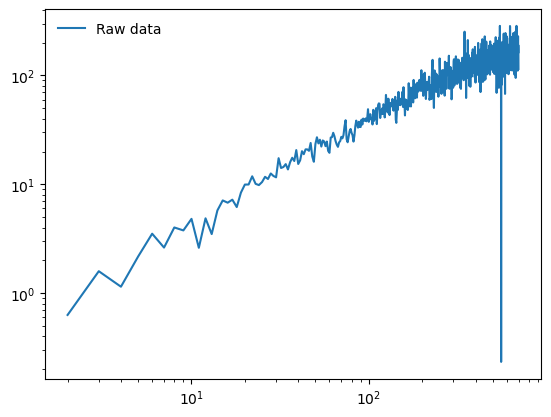

In [27]:
fit.plot_data()

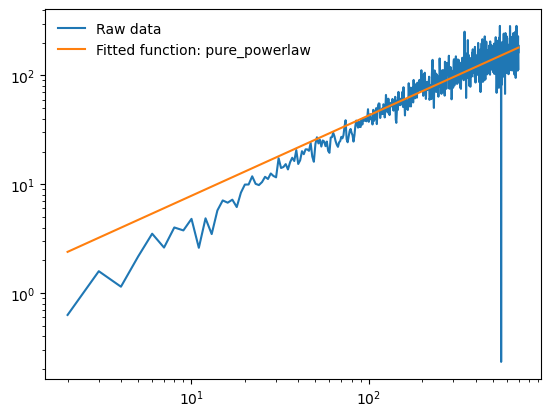

In [29]:
fit.pure_powerlaw.plot_fit()

In [30]:
def exponential_function(x: float, beta: float, lambda_: float) -> float:
    """
    Exponential function.

    Parameters:
    x (float): Input value.
    beta (float): Scaling constant.
    lambda_ (float): Exponential decay/growth parameter.

    Returns:
    float: Computed value.
    """
    return beta * np.exp(-lambda_ * x)

def powerlaw_with_exp_svf(x, alpha, beta, lambda_):
    return x ** alpha * exponential_function(x, beta, lambda_)

In [31]:
custom_powerlaw_funcs = {
    'powerlaw_with_exp_svf': powerlaw_with_exp_svf
}

# Fit custom function
fit.fit_powerlaw_function(custom_powerlaw_funcs)

In [32]:
R, p = fit.function_compare('powerlaw_with_exp_svf', 'exponential_function', nested = True)
fit.powerlaw_with_exp_svf.print_fitted_results()
fit.exponential_function.print_fitted_results()
print(f'Normalized Likelihood Ratio: {R}, p.value: {p}')


For powerlaw_with_exp_svf fitted using Nonlinear Least-squares;

Pre-fitting parameters:
xmin: 2.0

Fitting parameters:
param_names = ['alpha', 'beta', 'lambda_']
alpha = 1.1069382257569036
beta = 0.2805515272281418
lambda_ = 0.0012950072606938878

Goodness of fit to data:
D = 0.15902578796561603
bic = 6706.915611339293
Adjusted R-squared = 0.7305921008418141



For exponential_function fitted using Nonlinear Least-squares;

Pre-fitting parameters:
xmin: 2.0

Fitting parameters:
param_names = ['beta', 'lambda_']
beta = 47.291053096707714
lambda_ = -0.002041731415023682

Goodness of fit to data:
D = 0.17191977077363896
bic = 6951.310103947908
Adjusted R-squared = 0.6159328082263804


Normalized Likelihood Ratio: 7.65881712973435, p.value: 0.0


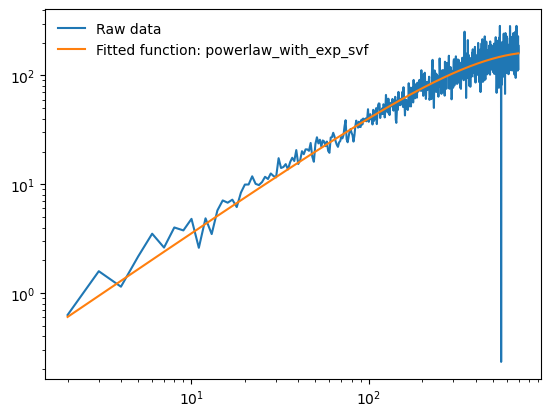

In [33]:
fit.powerlaw_with_exp_svf.plot_fit()

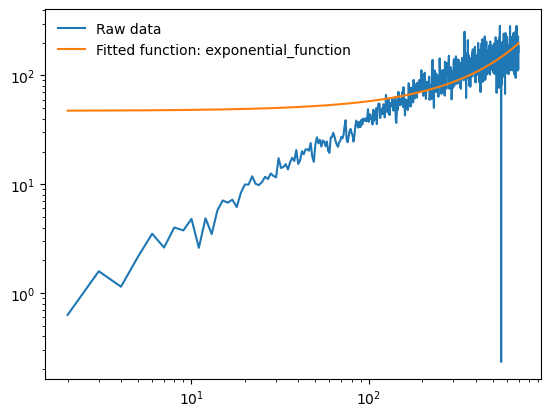

In [34]:
fit.exponential_function.plot_fit()

In [128]:
print